In [12]:
#import dgl
import numpy as np
import tensorflow as tf # tensorflow or _pytorch_?

import forgi
import forgi.graph.bulge_graph as fgb
import forgi.threedee as ft


import matplotlib.pyplot as plt
import networkx as nx

s0 ['i0']
i0 ['s0', 's1']
s1 ['i0', 'i1']
i1 ['s1', 's2']
s2 ['i1', 'm0', 'm3']
m0 ['s2', 's3']
s3 ['m0', 'h0', 'm1']
h0 ['s3']
m1 ['s3', 's4']
s4 ['m1', 'h1', 'm2']
h1 ['s4']
m2 ['s4', 's5']
s5 ['m2', 'h2', 'm3']
h2 ['s5']
m3 ['s2', 's5']
{'s0': ['i0'], 'i0': ['s0', 's1'], 's1': ['i0', 'i1'], 'i1': ['s1', 's2'], 's2': ['i1', 'm0', 'm3'], 'm0': ['s2', 's3'], 's3': ['m0', 'h0', 'm1'], 'h0': ['s3'], 'm1': ['s3', 's4'], 's4': ['m1', 'h1', 'm2'], 'h1': ['s4'], 'm2': ['s4', 's5'], 's5': ['m2', 'h2', 'm3'], 'h2': ['s5'], 'm3': ['s2', 's5']}


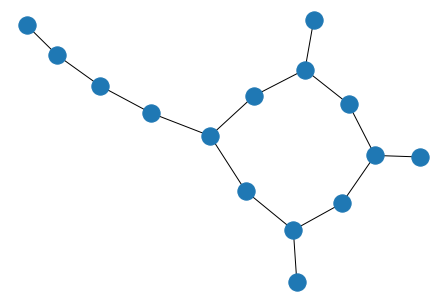

In [40]:
'''
Idea: load coarse grain representation with forgi,
    use forgi to form a graph with nodes labeled as s/i/o/.. and twist, length, angle,...
    use that graph to feed into model

TODO: use elements to get coords
    get elem connections
    build graph (use neato?) --> www.dgl.ai
    
    find where ernwin writes/stores output of structure for each n steps
'''

bg = fgb.BulgeGraph.from_bg_file("6cu1.cg")



stats = ft.model.stats.get_conformation_stats("6cu1.cg")



#https://viennarna.github.io/forgi/apidoc/forgi.threedee.model.coarse_grain.html
#cg = forgi.threedee.model.coarse_grain.CoarseGrainRNA.from_bg_string(bg)
#print(cg)


graph = nx.Graph()


# Get elements and neighbours:
connections = {}
labels_dir = {}
for elem in bg.sorted_element_iterator():
    neighbours = bg.connections(elem)
    print(elem, neighbours)
    
    for n in neighbours:
        graph.add_edge(elem, n)
    if elem not in connections:
        connections[elem] = bg.connections(elem)
print(connections)


nx.draw(graph)

In [68]:
def td_model():
    model = tf.keras.Sequential([
        tf.nn.layer.graph_convolution.feature_steered_convolution_layer(),
        tf.layers.Dense(1, activation=None)
    ])
